In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# Parameters for trust region
tol = 1e-6 # stop iterations when ||grad f|| < tol
iter_max = 200 # maximal number of iterations
Delta_max = 5 # max trust-region radius
Delta_min = 1e-12 # minimal trust-region radius
eta = 0.1 # step rejection parameter
subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
tol_sub = 1e-1 # relative tolerance for the subproblem
rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius

def cauchy_point(B, g, Delta):
    ng = np.linalg.norm(g)
    ps = -g * Delta / ng
    aux = np.dot(g, B @ g)
    if aux <= 0:
        p = ps
    else:
        a = np.minimum(ng**3 / (Delta * aux), 1)
        p = ps * a
    return p

In [3]:
# Delta = initial trust region radius
def trust_region(x, Delta):
    # initialization
    f = LJpot(x)
    g = LJgrad(x)
    norm_g = np.linalg.norm(g)
    print(f'Initially, f = {f}, ||grad f|| = {norm_g}')

    fvals = [f]
    ngvals = [norm_g]
    xvals = [x]

    I = np.eye(np.size(x), dtype=float)

    # the main trust-region cycle
    iter = 1
    while (norm_g > tol and iter < iter_max):
        # solve the constrained minimization problem
        B = LJhess(x)
        flag_boundary = 0
        # check if B is SPD
        eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
        j_sub = 0
        if eval_min > 0: # B is SPD: B = R' * R, R' * R * p = -g
            p = scipy.linalg.solve(B, -g)
            p_norm = np.linalg.norm(p)
            if p_norm > Delta: # else: we are done with solving the subproblem
                flag_boundary = 1
        else:
            flag_boundary = 1
        if flag_boundary == 1: # solution lies on the boundary
            lam_min = np.maximum(-eval_min, 0.0)
            lam = lam_min + 1
            R = scipy.linalg.cholesky(B + lam * I, lower=False)
            flag_subproblem_success = 0
            while j_sub < subproblem_iter_max:
                j_sub = j_sub + 1
                p = scipy.linalg.solve_triangular(np.transpose(R), -g, lower=True)
                p = scipy.linalg.solve_triangular(R, p, lower=False)
                p_norm = np.linalg.norm(p)
                dd = np.absolute(p_norm - Delta)
                if dd < tol_sub * Delta:
                    flag_subproblem_success = 1
                    break
                q = scipy.linalg.solve_triangular(np.transpose(R), p, lower=True)
                q_norm = np.linalg.norm(q)
                dlam = (p_norm / q_norm)**2 * (p_norm - Delta) / Delta
                lam_new = lam + dlam
                if lam_new > lam_min:
                    lam = lam_new
                else:
                    lam = 0.5 * (lam + lam_min)
                R = scipy.linalg.cholesky(B + lam * I, lower=False)
            if( flag_subproblem_success == 0 ):
                p = cauchy_point(B, g, Delta)
        # assess the progress
        xnew = x + p
        fnew = LJpot(xnew)
        gnew = LJgrad(xnew)
        mnew = f + np.dot(g, p) + 0.5 * np.dot(p, B @ p)
        rho = (f - fnew) / (f - mnew + 1e-14)
        # adjust the trust region
        if rho < rho_bad:
            Delta = np.maximum(0.25 * Delta, Delta_min)
        else:
            if rho > rho_good and flag_boundary == 1:
                Delta = np.minimum(Delta_max, 2 * Delta)
        # accept or reject step
        if rho > eta: # accept step
            x = xnew
            f = fnew
            g = gnew
            norm_g = np.linalg.norm(g)
            print(f'Accept: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
        else:
            print(f'Reject: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')

        fvals.append(f)
        ngvals.append(norm_g)
        xvals.append(x)
        iter += 1
    return fvals, ngvals, xvals

### 3. Minimizing Lennard-Jones Pair Potentials via Trust Region

In [4]:
# Four local minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid
# f2 = -15.93504306 Capped octahedron
# f3 = -15.59321094 Tricapped tetrahedron
# f4 = -15.53306005 Bicapped trigonal bipyramid

In [5]:
# Set up the initial configuration
Na = 7 # number of atoms
rstar = 2**(1 / 6) # minimizer of Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.
model = 0

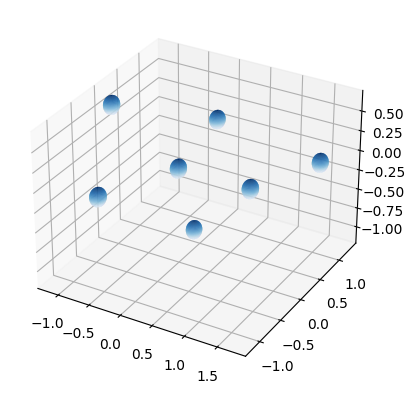

In [6]:
# select the initial configuration
xyz = initial_configuration(model, Na, rstar)
x = remove_rotations_translations(xyz)
drawconf(LJvector2array(x), 0.5 * rstar)

In [7]:
fvals, ngvals, xvals = trust_region(x, 1)

Initially, f = -8.110407232691175, ||grad f|| = 10.304072386230024
Reject: iter 1: f = -8.1104072327, |df| = 1.0304e+01, rho = -5.6373e+10, Delta = 2.5000e-01, j_sub = 2
Accept: iter 2: f = -8.6480216282, |df| = 2.1023e+01, rho = 2.5681e-01, Delta = 2.5000e-01, j_sub = 3
Accept: iter 3: f = -9.4914252653, |df| = 3.2718e+00, rho = 5.6876e-01, Delta = 2.5000e-01, j_sub = 2
Accept: iter 4: f = -10.0322373771, |df| = 2.3585e+00, rho = 8.4088e-01, Delta = 5.0000e-01, j_sub = 3
Accept: iter 5: f = -11.4073207817, |df| = 5.1365e+00, rho = 9.6673e-01, Delta = 1.0000e+00, j_sub = 2
Reject: iter 6: f = -11.4073207817, |df| = 5.1365e+00, rho = -3.9054e+01, Delta = 2.5000e-01, j_sub = 1
Accept: iter 7: f = -11.5579537211, |df| = 1.3074e+01, rho = 2.5847e-01, Delta = 2.5000e-01, j_sub = 3
Accept: iter 8: f = -12.4242400705, |df| = 3.9107e+00, rho = 8.3890e-01, Delta = 5.0000e-01, j_sub = 2
Reject: iter 9: f = -12.4242400705, |df| = 3.9107e+00, rho = -3.6031e-01, Delta = 1.2500e-01, j_sub = 2
Accept

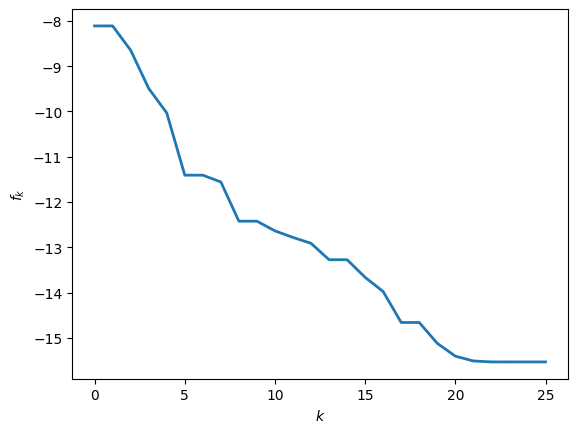

In [8]:
plt.plot(range(len(fvals)), fvals, linewidth=2)
plt.xlabel('$k$')
plt.ylabel('$f_k$')
plt.show()

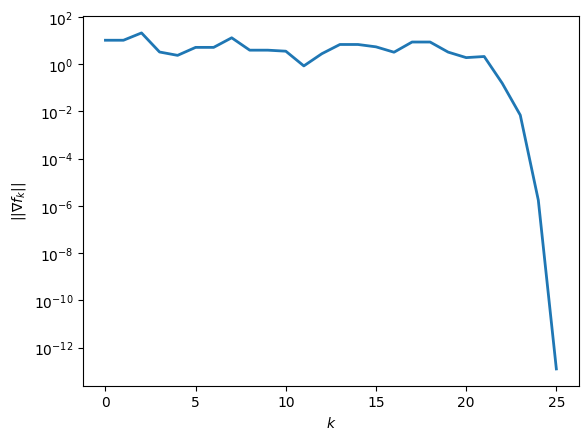

In [9]:
plt.plot(range(len(ngvals)), ngvals, linewidth=2)
plt.xlabel('$k$')
plt.ylabel('$||\\nabla f_k||$')
plt.yscale('log')
plt.show()

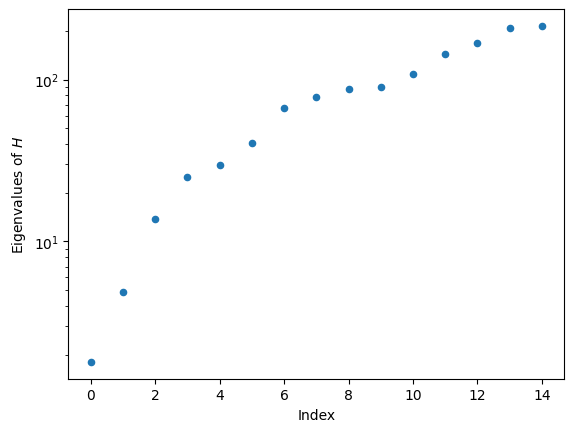

In [10]:
H = LJhess(xvals[-1])
evals = np.sort(np.linalg.eigvals(H))
plt.scatter(range(len(evals)), evals, s=20)
plt.xlabel('Index')
plt.ylabel('Eigenvalues of $H$')
if evals[0] > 0:
    plt.yscale('log')
plt.show()

### 4. Minimizing Rosenbrock Function via Trust Region